*Cleaning the data:*

Here we work with 2 data sources:
1. 1 Million Playlist Dataset
2. Spotify API

We downloaded and saved the 1,000,000 playlists as 1000 files in the folder 'Songs'

How we cleaned the data has been explained as we do it in the notebook.

The final dataset we work with contains playlist data taken from data source (1) and then song features for each song in those playlists from data source (2). We the data we prepared as csv for easy downloading.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity 
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

import seaborn as sns
sns.set(style='whitegrid')
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

In [ ]:
# The 1 million playlist data lives in 1000 separate files
# That amount of data will take a lot of time to work with
# Thus we randomly subset 10 files to work with 10000 playlists

np.random.seed(seed = 19)
numbers = np.arange(0,1000,1)
sample = np.random.choice(numbers, size=10, replace=True)
sample_pathname = ['Songs/songs'] * 10 
for number in range(10):
    string = 'Songs/songs' + str(sample[number]) + '.csv'
    sample_pathname[number] = string

print("Playlist files we will use by random selection:")
print("10 files should give us 10,000 playlists")
sample_pathname


In [ ]:
# Saving those 10 playlist file path in a list
# They are saved in a folder named Songs
# There are 1000 files with 1000 playlists in each
playlist_list = []
for path in sample_pathname:
    df = pd.read_csv(path)
    playlist_list.append(df)

In [ ]:
# We want to get a dataframe with 10,000 playlists
# Making sure the 10,000 playlists have a different  or playlist id
for i in range(10):
    playlist_list[i]['pid'] = playlist_list[i]['pid'] + 1000*i
    
# Combining the 10,000 playlist into a single df
df = playlist_list[0]
for i in range(1,10):
    df = df.append(playlist_list[i], ignore_index=True)
df.tail(10)

In [ ]:
# Saving as csv file
df.to_csv("data/Sample_from_Million_Playlist.csv")


In [ ]:
# Getting data from Spotify api
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

client_credentials_manager = SpotifyClientCredentials('ca4bc09f475c428ea4a78ac1149aa78b', '14d5874e3c1545579dd97bce7c79a852', None)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)


In [ ]:
# We have 10,000 playlists

# It's hard time consuming to bring data from spotify for over 663,000 songs
# I tried 1000 playlists and spotify didn't allow me to get that much data
# Let's choose a small subset, 100 playlists in random and bring spotify data for those songs

np.random.seed(seed = 10)
numbers2 = np.arange(0,10000,1)
sample2 = np.random.choice(numbers, size=200, replace=True)
small_df = df[df['pid'].isin(sample2)]

# Removing 28 songs such that we can send larger requests (100 requests at a time) to spotify 
small_df = small_df.iloc[:12100,:]

In [ ]:
# Got track info on 12,100 songs
track_info = []
mah_tracks_uri = list(small_df['track_uri'])
counts = list(np.arange(0,12100,100))
for count in counts:
    
    # This is the part we get data from Spotify
    # Usually takes a long time to implement
    for x in mah_tracks_uri[count:count+100]:
        song = sp.audio_features(tracks= x)[0]
        track_info.append(song)
        
# We have a dataframe with info on each track
track_info_df = pd.DataFrame(track_info)
track_info_df.head(10)

In [ ]:
# Merging the two dataframes
df_spotify = pd.concat([small_df.reset_index(), track_info_df], axis=1)
df_spotify.head(10)

# Saving as csv file
# This file below will be used in our analysis files
df_spotify.to_csv("data/100_Sample_MilPlay_Spotify.csv")

In [2]:
# Reading the dataframe to start working
df = pd.read_csv("data/Sample_from_Million_Playlist.csv")
# Reading the data from saved file
# This is the dataframe we will implement our mode
df_spotify = pd.read_csv("data/100_Sample_MilPlay_Spotify.csv")
df_spotify.head(10)

,pid,pos,artist_name,track_uri,artist_uri,track_name,album_uri,duration_ms,album_name,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms.1,time_signature
0,4,0,Alessia Cara,spotify:track:1wYZZtamWTQAoj8B812uKQ,spotify:artist:2wUjUUtkb5lvLKcGKsKqsR,Here,spotify:album:3rDbA12I5duZnlwakqDdZa,199453,Know-It-All,0.376,0.821,0,-3.974,1,0.1040,0.0785,0.000000,0.0823,0.331,120.462,audio_features,1wYZZtamWTQAoj8B812uKQ,spotify:track:1wYZZtamWTQAoj8B812uKQ,https://api.spotify.com/v1/tracks/1wYZZtamWTQA...,https://api.spotify.com/v1/audio-analysis/1wYZ...,199453,4
1,4,1,The Weeknd,spotify:track:0Gi17qCJh9e9RJxLaYkm9l,spotify:artist:1Xyo4u8uXC1ZmMpatF05PJ,Dark Times,spotify:album:28ZKQMoNBB0etKXZ97G2SN,260640,Beauty Behind The Madness,0.585,0.421,7,-9.593,1,0.0707,0.1060,0.000010,0.1400,0.240,132.986,audio_features,0Gi17qCJh9e9RJxLaYkm9l,spotify:track:0Gi17qCJh9e9RJxLaYkm9l,https://api.spotify.com/v1/tracks/0Gi17qCJh9e9...,https://api.spotify.com/v1/audio-analysis/0Gi1...,260640,3
2,4,2,J. Cole,spotify:track:6Ius4TC0L3cN74HT7ENE6e,spotify:artist:6l3HvQ5sa6mXTsMTB19rO5,Wet Dreamz,spotify:album:7viNUmZZ8ztn2UB4XB3jIL,239320,2014 Forest Hills Drive,0.504,0.705,6,-8.205,0,0.3640,0.0752,0.000000,0.1280,0.584,175.483,audio_features,6Ius4TC0L3cN74HT7ENE6e,spotify:track:6Ius4TC0L3cN74HT7ENE6e,https://api.spotify.com/v1/tracks/6Ius4TC0L3cN...,https://api.spotify.com/v1/audio-analysis/6Ius...,239320,4
3,4,3,Chance The Rapper,spotify:track:0jx8zY5JQsS4YEQcfkoc5C,spotify:artist:1anyVhU62p31KFi8MEzkbf,Angels (feat. Saba),spotify:album:71QyofYesSsRMwFOTafnhB,206240,Coloring Book,0.771,0.647,5,-5.127,0,0.3760,0.2940,0.000000,0.3700,0.678,155.914,audio_features,0jx8zY5JQsS4YEQcfkoc5C,spotify:track:0jx8zY5JQsS4YEQcfkoc5C,https://api.spotify.com/v1/tracks/0jx8zY5JQsS4...,https://api.spotify.com/v1/audio-analysis/0jx8...,206240,4
4,4,4,The Weeknd,spotify:track:7fPHfBCyKE3aVCBjE4DAvl,spotify:artist:1Xyo4u8uXC1ZmMpatF05PJ,In The Night,spotify:album:28ZKQMoNBB0etKXZ97G2SN,235653,Beauty Behind The Madness,0.480,0.682,7,-4.940,1,0.1300,0.0696,0.000000,0.0463,0.506,167.939,audio_features,7fPHfBCyKE3aVCBjE4DAvl,spotify:track:7fPHfBCyKE3aVCBjE4DAvl,https://api.spotify.com/v1/tracks/7fPHfBCyKE3a...,https://api.spotify.com/v1/audio-analysis/7fPH...,235653,3
5,4,5,Donnie Trumpet & The Social Experiment,spotify:track:6fTdcGsjxlAD9PSkoPaLMX,spotify:artist:0ojcq9LJQWMawQdFDw3M0L,Sunday Candy,spotify:album:3eM1KTKmpqrQOvuvYY42cr,226013,Surf,0.511,0.596,0,-6.560,1,0.2240,0.5300,0.000000,0.0798,0.554,158.063,audio_features,6fTdcGsjxlAD9PSkoPaLMX,spotify:track:6fTdcGsjxlAD9PSkoPaLMX,https://api.spotify.com/v1/tracks/6fTdcGsjxlAD...,https://api.spotify.com/v1/audio-analysis/6fTd...,226014,4
6,4,6,Beyoncé,spotify:track:2CvOqDpQIMw69cCzWqr5yr,spotify:artist:6vWDO969PvNqNYHIOW5v0m,Halo,spotify:album:3ROfBX6lJLnCmaw1NrP5K9,261160,I AM...SASHA FIERCE - Platinum Edition,0.422,0.712,11,-5.907,0,0.1000,0.2730,0.000000,0.0510,0.471,78.454,audio_features,2CvOqDpQIMw69cCzWqr5yr,spotify:track:2CvOqDpQIMw69cCzWqr5yr,https://api.spotify.com/v1/tracks/2CvOqDpQIMw6...,https://api.spotify.com/v1/audio-analysis/2CvO...,261160,4
7,4,7,Hozier,spotify:track:1ivHxaGL5ld9VS1zsYc4YN,spotify:artist:2FXC3k01G6Gw61bmprjgqS,Cherry Wine - Live,spotify:album:36k5aXpxffjVGcNce12GLZ,240147,Hozier,0.418,0.111,1,-14.848,1,0.0389,0.9530,0.003420,0.0982,0.228,82.508,audio_features,1ivHxaGL5ld9VS1zsYc4YN,spotify:track:1ivHxaGL5ld9VS1zsYc4YN,https://api.spotify.com/v1/tracks/1ivHxaGL5ld9...,https://api.spotify.com/v1/audio-analysis/1ivH...,240147,4
8,4,8,Hozier,spotify:track:1TGimSbipZ3XZ7q3eszBRV,spotify:artist:2FXC3k01G6Gw61bmprjgqS,Angel Of Small Death & The Codeine Scene,spotify:album:36k5aXpxffjVGcNce12GLZ,219214,Hozier,0.377,0.638,4,-5.754,1,0.0545,0.2130,0.000080,0.1200,0.369,92.644,audio_features,1TGimSbipZ3XZ7q3eszBRV,spotify:track:1TGimSbipZ3XZ7q3eszBRV,https://api.spotify.com/v1/tracks/1TGimSbipZ3X...,ht

**Note:**
Before we use this data for all our analysis, it is crucial to see that the data is indeed random and that our selected playlists display strong variety

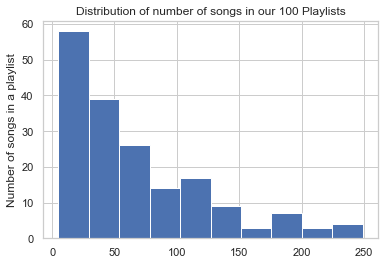

In [8]:
plt.hist(df_spotify['pid'].value_counts())
plt.title("Distribution of number of songs in our 100 Playlists")
plt.ylabel("Count")
plt.ylabel("Number of songs in a playlist")
plt.show()

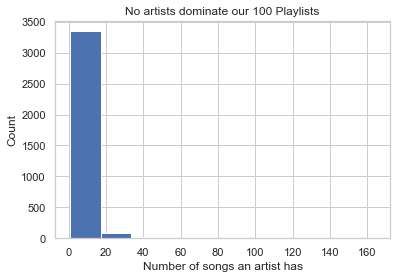

In [11]:
plt.hist(df_spotify['artist_name'].value_counts())
plt.title("No artists dominate our 100 Playlists")
plt.ylabel("Count")
plt.xlabel("Number of songs an artist has")
plt.show()

Text(0.5, 0, 'Total songs across playlists')

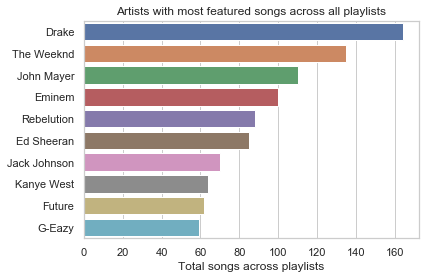

In [15]:
# Checking which artists are featured most across all playlists
values = list(df_spotify['artist_name'].value_counts())
names = df_spotify['artist_name'].value_counts().index.tolist()

ax = sns.barplot(y=names[0:10], x=values[0:10])
ax.set_title('Artists with most featured songs across all playlists')
ax.set_xlabel('Total songs across playlists')

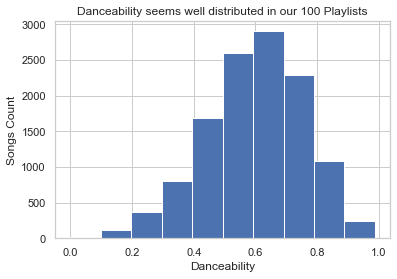

In [16]:
plt.hist(df_spotify['danceability'])
plt.title("Danceability seems well distributed in our 100 Playlists")
plt.ylabel("Songs Count")
plt.xlabel("Danceability")
plt.show()

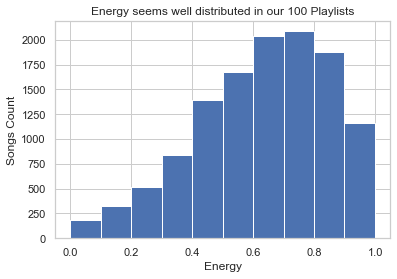

In [17]:
plt.hist(df_spotify['energy'])
plt.title("Energy seems well distributed in our 100 Playlists")
plt.ylabel("Songs Count")
plt.xlabel("Energy")
plt.show()

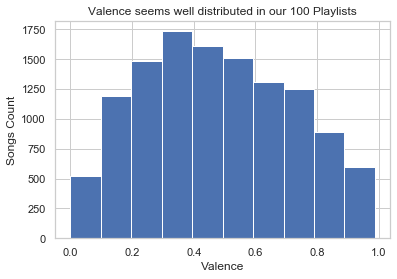

In [18]:
plt.hist(df_spotify['valence'])
plt.title("Valence seems well distributed in our 100 Playlists")
plt.ylabel("Songs Count")
plt.xlabel("Valence")
plt.show()

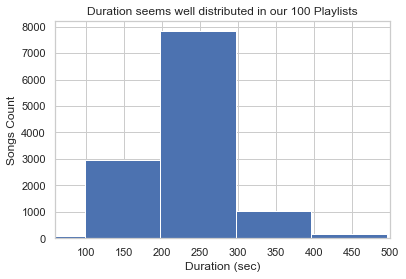

In [20]:
plt.hist(df_spotify['duration_ms']/1000)
plt.title("Duration seems well distributed in our 100 Playlists")
plt.ylabel("Songs Count")
plt.xlabel("Duration (sec)")
plt.xlim(60,500)
plt.show()